In [139]:
import networkx as nx
import pandas as pd
import random
import torch
import pickle
from sklearn.model_selection import train_test_split
import numpy as np

In [140]:
import torch
from torch_geometric.utils.convert import from_networkx
from pygod.detector import DOMINANT, OCGNN, CONAD, GAE, AnomalyDAE
from pygod.metric import eval_average_precision, eval_roc_auc, eval_f1, eval_precision_at_k, eval_recall_at_k
import pickle
import time

## Graph

### Load Graph Skenario  1

In [141]:
train_graph = pickle.load(open('model_graph/train_graph.pkl', 'rb'))
label_train = pickle.load(open('model_graph/label_train.pkl', 'rb'))
train_node_features = pickle.load(open('model_graph/train_node_features.pkl', 'rb'))

In [142]:
test_graph = pickle.load(open('model_graph/test_graph.pkl', 'rb'))
label_test = pickle.load(open('model_graph/label_test.pkl', 'rb'))
test_node_features = pickle.load(open('model_graph/test_node_features.pkl', 'rb'))

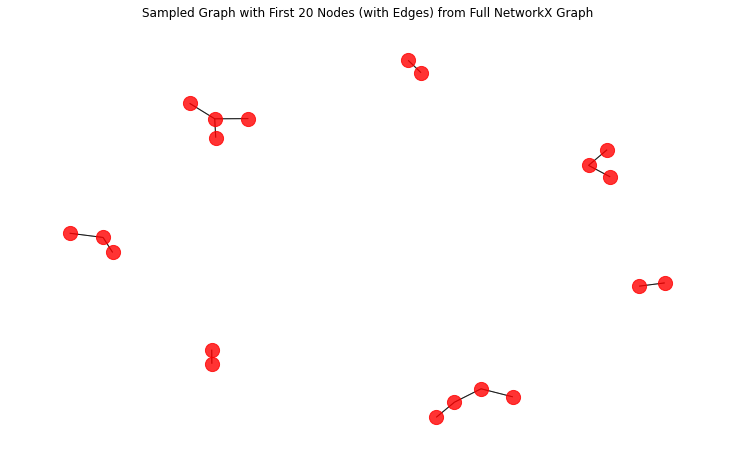

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have your full graph stored in 'train_graph'
# Initialize an empty subgraph
sampled_graph = nx.Graph()

# Get the nodes with edges until we have 20 nodes
desired_num_nodes = 20
for node in train_graph.nodes():
    # Add the node and its edges to the sampled graph
    if len(train_graph.edges(node)) > 0:
        sampled_graph.add_node(node)
        sampled_graph.add_edges_from(train_graph.edges(node))
        
    # Break the loop if we have reached the desired number of nodes
    if len(sampled_graph.nodes()) >= desired_num_nodes:
        break

# Visualize the sampled graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(sampled_graph, seed=42)

# Draw nodes and edges
nx.draw(sampled_graph, pos, with_labels=False, node_color='red', node_size=200, font_size=8, font_weight='bold', alpha=0.8)
nx.draw_networkx_edges(sampled_graph, pos, edge_color='black', alpha=0.5)

plt.title("Sampled Graph with First 20 Nodes (with Edges) from Full NetworkX Graph")
plt.axis('off')
plt.show()


In [5]:
## number of nodes
print(train_graph.number_of_nodes())
print(test_graph.number_of_nodes())

15451
9525


In [6]:
# print num of isolated nodes
print(len(list(nx.isolates(train_graph))))
# print num of isolated nodes
print(len(list(nx.isolates(test_graph))))

0
0


In [7]:
#convert label_train to numpy array
label_train_np = np.array(label_train)
label_train_torch = torch.from_numpy(label_train_np)
unique, counts = torch.unique(label_train_torch, return_counts=True)
dict(zip(unique, counts))

{tensor(0): tensor(10070), tensor(1): tensor(5381)}

### Load Graph Skenario 2

In [143]:
train_graph_2 = pickle.load(open('model_graph/train_graph_port.pkl', 'rb'))
label_train_2 = pickle.load(open('model_graph/label_train_port.pkl', 'rb'))
train_node_features_2 = pickle.load(open('model_graph/train_node_features_ip_port.pkl', 'rb'))

In [144]:
test_graph_2 = pickle.load(open('model_graph/test_graph_port.pkl', 'rb'))
label_test_2 = pickle.load(open('model_graph/label_test_port.pkl', 'rb'))
test_node_features_2 = pickle.load(open('model_graph/test_node_features_port.pkl', 'rb'))

In [10]:
# print num of isolated nodes
print(len(list(nx.isolates(train_graph_2))))
# print num of isolated nodes
print(len(list(nx.isolates(test_graph_2))))

11213
6999


In [11]:
## number of nodes
print(train_graph_2.number_of_nodes())
print(test_graph_2.number_of_nodes())

15480
8604


In [12]:
print(len(label_train_2))
print(len(label_test_2))

15480
8604


### Load Graph Skenario 3

In [145]:
train_graph_3 = pickle.load(open('model_graph/train_graph_ip_port.pkl', 'rb'))
label_train_3 = pickle.load(open('model_graph/label_train_ip_port.pkl', 'rb'))
train_node_features_3 = pickle.load(open('model_graph/train_node_features_ip_port.pkl', 'rb'))

In [146]:
test_graph_3 = pickle.load(open('model_graph/test_graph_ip_port.pkl', 'rb'))
label_test_3 = pickle.load(open('model_graph/label_test_ip_port.pkl', 'rb'))
test_node_features_3 = pickle.load(open('model_graph/test_node_features_ip_port.pkl', 'rb'))

In [15]:
# print num of isolated nodes
print(len(list(nx.isolates(train_graph_3))))
# print num of isolated nodes
print(len(list(nx.isolates(test_graph_3))))

13629
7832


In [16]:
## number of nodes
print(train_graph_3.number_of_nodes())
print(test_graph_3.number_of_nodes())

15480
8604


In [17]:
print(len(train_node_features_3))
print(len(test_node_features_3))

15480
8604


In [18]:
print(len(label_train_3))
print(len(label_test_3))

15480
8604


## Model with default parameter

### DOMINANT

In [22]:
def predict_dominant(label_test, dominant_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features
    print(pyG_test.x.shape)
    dominant_ip_pred_res, dominant_ip_score_res = dominant_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True)
    
    precision_pygod = eval_precision_at_k(label_test, dominant_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, dominant_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return precision_pygod, recall_pygod, f1_score

def make_dominant_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features
    print(pyG_train.x.shape)
    dominant_model = DOMINANT(epoch=100, verbose=3, gpu=0)
    dominant_compile = dominant_model.fit(pyG_train)
    return dominant_compile

#### skenario 1

In [23]:
dominant_model = make_dominant_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_dominant(label_test, dominant_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3770037017.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)
C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3770037017.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train)


torch.Size([15451, 1])
Epoch 0000: Loss 1251037.0000 |  | Time 8.37
Epoch 0001: Loss 479677.5000 |  | Time 0.78
Epoch 0002: Loss 180111.0625 |  | Time 0.63
Epoch 0003: Loss 114140.8672 |  | Time 0.60
Epoch 0004: Loss 115923.6719 |  | Time 0.63
Epoch 0005: Loss 117729.3906 |  | Time 0.64
Epoch 0006: Loss 108468.5703 |  | Time 0.71
Epoch 0007: Loss 94579.0234 |  | Time 0.67
Epoch 0008: Loss 81210.1719 |  | Time 0.67
Epoch 0009: Loss 69354.3203 |  | Time 0.66
Epoch 0010: Loss 58392.9844 |  | Time 0.61
Epoch 0011: Loss 47929.6328 |  | Time 0.66
Epoch 0012: Loss 38240.6328 |  | Time 0.65
Epoch 0013: Loss 30103.3320 |  | Time 0.72
Epoch 0014: Loss 24169.4395 |  | Time 0.70
Epoch 0015: Loss 20446.4707 |  | Time 0.69
Epoch 0016: Loss 18301.3789 |  | Time 0.67
Epoch 0017: Loss 16929.3477 |  | Time 0.65
Epoch 0018: Loss 15790.0986 |  | Time 0.67
Epoch 0019: Loss 14681.0840 |  | Time 0.70
Epoch 0020: Loss 13584.8516 |  | Time 0.67
Epoch 0021: Loss 12515.0049 |  | Time 0.65
Epoch 0022: Loss 11453.

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3770037017.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


torch.Size([9525, 1])
Test: Loss 0.0045 | AUC 0.7327 | Recall 0.6297 | Precision 0.6297 | AP 0.7347 | F1 0.6297 | Time 0.15
F1 score:  tensor(0.6297)
Precision:  tensor(0.6297)
Recall:  tensor(0.6297)


In [25]:
## export dominant_model
pickle.dump(dominant_model, open('ml-model/dominant_model_default_1.pickle', 'wb'))

In [26]:
dominant_model_default = pickle.load(open('ml-model/dominant_model_default_1.pickle', 'rb'))
precision_score, recall_score, f1_score = predict_dominant(label_test, dominant_model_default, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3770037017.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


torch.Size([9525, 1])
Test: Loss 0.0045 | AUC 0.7327 | Recall 0.6297 | Precision 0.6297 | AP 0.7347 | F1 0.6297 | Time 0.30
F1 score:  tensor(0.6297)
Precision:  tensor(0.6297)
Recall:  tensor(0.6297)


#### skenario 2

In [25]:
dominant_model = make_dominant_model(train_graph_2, train_node_features_2, label_train_2)
precision_score, recall_score, f1_score = predict_dominant(label_test_2, dominant_model, test_graph_2, test_node_features_2)

torch.Size([15480, 1])


IndexError: index 15473 is out of bounds for dimension 0 with size 15473

#### skenario 3

In [45]:
dominant_model = make_dominant_model(train_graph_3, train_node_features_3, label_train_3)
precision_score, recall_score, f1_score = predict_dominant(label_test_3, dominant_model, test_graph_3, test_node_features_3)

torch.Size([15480, 1])


IndexError: index 15473 is out of bounds for dimension 0 with size 15473

### OCGNN

In [32]:
def predict_ocgnn(label_test, ocgnn_compile, pyG_test, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(pyG_test)
    pyG_test.x = test_node_features

    ocgnn_ip_pred_res, ocgnn_ip_score_res = ocgnn_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')

    precision_pygod = eval_precision_at_k(label_test, ocgnn_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, ocgnn_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)

    return precision_pygod, recall_pygod, f1_score

def make_ocgnn_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features

    ocgnn_model = OCGNN(epoch=100, verbose=3)
    ocgnn_compile = ocgnn_model.fit(pyG_train)
    return ocgnn_compile

#### skenario 1

In [33]:
ocgnn_model = make_ocgnn_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_ocgnn(label_test, ocgnn_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2431339799.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 84627.2891 |  | Time 0.07
Epoch 0001: Loss 48232.7891 |  | Time 0.08
Epoch 0002: Loss 32310.5918 |  | Time 0.07
Epoch 0003: Loss 21133.0664 |  | Time 0.08
Epoch 0004: Loss 13929.8438 |  | Time 0.09
Epoch 0005: Loss 9903.6582 |  | Time 0.08
Epoch 0006: Loss 8189.5498 |  | Time 0.08
Epoch 0007: Loss 8261.3701 |  | Time 0.08
Epoch 0008: Loss 9035.1221 |  | Time 0.08
Epoch 0009: Loss 9858.8828 |  | Time 0.07
Epoch 0010: Loss 10427.3545 |  | Time 0.07
Epoch 0011: Loss 10648.3857 |  | Time 0.08
Epoch 0012: Loss 10556.7305 |  | Time 0.08
Epoch 0013: Loss 10227.5811 |  | Time 0.08
Epoch 0014: Loss 9733.3584 |  | Time 0.08
Epoch 0015: Loss 9137.4248 |  | Time 0.09
Epoch 0016: Loss 8500.4785 |  | Time 0.08
Epoch 0017: Loss 7879.9004 |  | Time 0.09
Epoch 0018: Loss 7320.9775 |  | Time 0.08
Epoch 0019: Loss 6849.3452 |  | Time 0.08
Epoch 0020: Loss 6470.0444 |  | Time 0.08
Epoch 0021: Loss 6214.6934 |  | Time 0.08
Epoch 0022: Loss 6071.5713 |  | Time 0.09
Epoch 0023: Loss 5991.960

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2431339799.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.4651 | AUC 0.1470 | Recall 0.1036 | Precision 0.1036 | AP 0.3154 | F1 0.1036 | Time 0.03
F1 score:  tensor(0.1036)
Precision:  tensor(0.1036)
Recall:  tensor(0.1036)


In [37]:
## export dominant_model
pickle.dump(ocgnn_model, open('ml-model/ocgnn_model_default_1.pickle', 'wb'))

In [38]:
ocgnn_model_default = pickle.load(open('ml-model/ocgnn_model_default_1.pickle', 'rb'))

In [39]:
ocgnn_precision, ocgnn_recall, ocgnn_f1 = predict_ocgnn(label_test, ocgnn_model_default, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2431339799.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.4651 | AUC 0.1470 | Recall 0.1036 | Precision 0.1036 | AP 0.3154 | F1 0.1036 | Time 0.02
F1 score:  tensor(0.1036)
Precision:  tensor(0.1036)
Recall:  tensor(0.1036)


#### skenario 2

In [40]:
ocgnn_model = make_ocgnn_model(train_graph_2, train_node_features_2, label_train_2)
precision_score, recall_score, f1_score = predict_ocgnn(label_test_2, ocgnn_model, test_graph_2, test_node_features_2)

Epoch 0000: Loss 305987.4375 |  | Time 0.05
Epoch 0001: Loss 227769.3438 |  | Time 0.06
Epoch 0002: Loss 177402.9531 |  | Time 0.05
Epoch 0003: Loss 138141.0156 |  | Time 0.05
Epoch 0004: Loss 107332.7891 |  | Time 0.05
Epoch 0005: Loss 83414.3516 |  | Time 0.09
Epoch 0006: Loss 65243.4141 |  | Time 0.06
Epoch 0007: Loss 51573.9883 |  | Time 0.07
Epoch 0008: Loss 41482.0547 |  | Time 0.06
Epoch 0009: Loss 34151.5859 |  | Time 0.06
Epoch 0010: Loss 28940.9961 |  | Time 0.07
Epoch 0011: Loss 25246.7578 |  | Time 0.05
Epoch 0012: Loss 22592.5078 |  | Time 0.05
Epoch 0013: Loss 20666.0078 |  | Time 0.05
Epoch 0014: Loss 19221.0703 |  | Time 0.06
Epoch 0015: Loss 18078.3516 |  | Time 0.05
Epoch 0016: Loss 17126.9902 |  | Time 0.06
Epoch 0017: Loss 16304.9697 |  | Time 0.06
Epoch 0018: Loss 15573.3018 |  | Time 0.06
Epoch 0019: Loss 14903.1270 |  | Time 0.05
Epoch 0020: Loss 14277.9668 |  | Time 0.05
Epoch 0021: Loss 13697.8721 |  | Time 0.05
Epoch 0022: Loss 13169.3184 |  | Time 0.06
Epoch 

In [41]:
## export dominant_model
pickle.dump(ocgnn_model, open('ml-model/ocgnn_model_default_2.pickle', 'wb'))

In [42]:
ocgnn_model_default_2 = pickle.load(open('ml-model/ocgnn_model_default_2.pickle', 'rb'))

In [43]:
ocgnn_precision, ocgnn_recall, ocgnn_f1 = predict_ocgnn(label_test, ocgnn_model_default_2, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2431339799.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.7272 | AUC 0.1208 | Recall 0.1022 | Precision 0.1022 | AP 0.2874 | F1 0.1022 | Time 0.02
F1 score:  tensor(0.1022)
Precision:  tensor(0.1022)
Recall:  tensor(0.1022)


#### skenario 3

In [44]:
ocgnn_model = make_ocgnn_model(train_graph_3, train_node_features_3, label_train_3)
precision_score, recall_score, f1_score = predict_ocgnn(label_test_3, ocgnn_model, test_graph_3, test_node_features_3)

Epoch 0000: Loss 144234.2500 |  | Time 0.05
Epoch 0001: Loss 101070.1719 |  | Time 0.04
Epoch 0002: Loss 73365.2031 |  | Time 0.04
Epoch 0003: Loss 53031.4844 |  | Time 0.05
Epoch 0004: Loss 38156.2695 |  | Time 0.05
Epoch 0005: Loss 27504.9160 |  | Time 0.05
Epoch 0006: Loss 20110.7754 |  | Time 0.07
Epoch 0007: Loss 15119.7480 |  | Time 0.06
Epoch 0008: Loss 11996.8633 |  | Time 0.07
Epoch 0009: Loss 10192.8271 |  | Time 0.09
Epoch 0010: Loss 9277.3184 |  | Time 0.06
Epoch 0011: Loss 8926.6875 |  | Time 0.07
Epoch 0012: Loss 8879.2900 |  | Time 0.05
Epoch 0013: Loss 8943.8096 |  | Time 0.06
Epoch 0014: Loss 8996.3516 |  | Time 0.04
Epoch 0015: Loss 8971.2051 |  | Time 0.05
Epoch 0016: Loss 8845.5469 |  | Time 0.05
Epoch 0017: Loss 8622.3555 |  | Time 0.05
Epoch 0018: Loss 8315.9355 |  | Time 0.05
Epoch 0019: Loss 7945.6392 |  | Time 0.05
Epoch 0020: Loss 7535.1831 |  | Time 0.06
Epoch 0021: Loss 7110.9917 |  | Time 0.05
Epoch 0022: Loss 6696.8374 |  | Time 0.06
Epoch 0023: Loss 6307.

In [45]:
## export dominant_model
pickle.dump(ocgnn_model, open('ml-model/ocgnn_model_default_3.pickle', 'wb'))

In [46]:
ocgnn_model_default_3 = pickle.load(open('ml-model/ocgnn_model_default_3.pickle', 'rb'))

In [47]:
ocgnn_precision, ocgnn_recall, ocgnn_f1 = predict_ocgnn(label_test, ocgnn_model_default_3, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2431339799.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.2758 | AUC 0.1216 | Recall 0.1024 | Precision 0.1024 | AP 0.2876 | F1 0.1018 | Time 0.03
F1 score:  tensor(0.1024)
Precision:  tensor(0.1024)
Recall:  tensor(0.1024)


### GAE

In [50]:
def predict_gae(label_test, gae_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features

    gae_ip_pred_res, gae_ip_score_res = gae_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')
    precision = eval_precision_at_k(label_test, gae_ip_score_res)
    recall = eval_recall_at_k(label_test, gae_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    
    return precision, recall, f1_score
    
def make_gae_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train
    pyG_train.x = train_node_features
    label_train = label_train

    gae_model = GAE(epoch=100, verbose=3, gpu=-1)
    gae_compile = gae_model.fit(pyG_train, label_train)
    return gae_compile

#### skenario 1

In [51]:
gae_model = make_gae_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_gae(label_test, gae_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 109439.8125 | AUC 0.6821 | Recall 0.5376 | Precision 0.5376 | AP 0.5872 | F1 0.5376 | Time 0.18
Epoch 0001: Loss 97385.5312 | AUC 0.6782 | Recall 0.5341 | Precision 0.5341 | AP 0.5960 | F1 0.5341 | Time 0.12
Epoch 0002: Loss 88636.7422 | AUC 0.7068 | Recall 0.5835 | Precision 0.5835 | AP 0.6405 | F1 0.5836 | Time 0.11
Epoch 0003: Loss 82179.5078 | AUC 0.7484 | Recall 0.6478 | Precision 0.6478 | AP 0.6770 | F1 0.6479 | Time 0.12
Epoch 0004: Loss 77310.2500 | AUC 0.7879 | Recall 0.6333 | Precision 0.6333 | AP 0.7094 | F1 0.6333 | Time 0.12
Epoch 0005: Loss 74287.6094 | AUC 0.8143 | Recall 0.6231 | Precision 0.6231 | AP 0.7244 | F1 0.6231 | Time 0.12
Epoch 0006: Loss 73743.0312 | AUC 0.8096 | Recall 0.6136 | Precision 0.6136 | AP 0.7307 | F1 0.6136 | Time 0.13
Epoch 0007: Loss 75513.5000 | AUC 0.8057 | Recall 0.6140 | Precision 0.6140 | AP 0.7424 | F1 0.6140 | Time 0.13
Epoch 0008: Loss 77708.5391 | AUC 0.8072 | Recall 0.6172 | Precision 0.6172 | AP 0.7509 | F1 0.6172 | T

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 11.3603 | AUC 0.8269 | Recall 0.7079 | Precision 0.7079 | AP 0.8049 | F1 0.7079 | Time 0.04
F1 score:  tensor(0.7079)
Precision:  tensor(0.7079)
Recall:  tensor(0.7079)


In [52]:
## export dominant_model
pickle.dump(gae_model, open('ml-model/gae_model_default_1.pickle', 'wb'))

In [147]:
gae_model_default = pickle.load(open('ml-model/gae_model_default_1.pickle', 'rb'))

In [148]:
precision, recall, f1 = predict_gae(label_test, gae_model_default, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 11.3603 | AUC 0.8269 | Recall 0.7079 | Precision 0.7079 | AP 0.8049 | F1 0.7079 | Time 0.06
F1 score:  tensor(0.7079)
Precision:  tensor(0.7079)
Recall:  tensor(0.7079)


#### skenario 2

In [55]:
gae_model = make_gae_model(train_graph_2, train_node_features_2, label_train_2)
precision_score, recall_score, f1_score = predict_gae(label_test_2, gae_model, test_graph_2, test_node_features_2)

Epoch 0000: Loss 150562.7031 | AUC 0.7831 | Recall 0.6683 | Precision 0.6683 | AP 0.6491 | F1 0.7163 | Time 0.08
Epoch 0001: Loss 81834.0156 | AUC 0.7770 | Recall 0.6520 | Precision 0.6520 | AP 0.6427 | F1 0.6718 | Time 0.09
Epoch 0002: Loss 46966.7656 | AUC 0.7625 | Recall 0.6566 | Precision 0.6566 | AP 0.6212 | F1 0.6682 | Time 0.09
Epoch 0003: Loss 27543.0078 | AUC 0.7513 | Recall 0.6707 | Precision 0.6707 | AP 0.5956 | F1 0.6703 | Time 0.09
Epoch 0004: Loss 17735.6562 | AUC 0.6986 | Recall 0.5250 | Precision 0.5250 | AP 0.5343 | F1 0.5250 | Time 0.07
Epoch 0005: Loss 17373.9395 | AUC 0.6759 | Recall 0.5080 | Precision 0.5080 | AP 0.5064 | F1 0.5069 | Time 0.07
Epoch 0006: Loss 22986.9766 | AUC 0.6917 | Recall 0.6186 | Precision 0.6186 | AP 0.5338 | F1 0.6031 | Time 0.07
Epoch 0007: Loss 28433.4512 | AUC 0.6881 | Recall 0.6130 | Precision 0.6130 | AP 0.5356 | F1 0.6149 | Time 0.07
Epoch 0008: Loss 29441.6836 | AUC 0.6882 | Recall 0.6117 | Precision 0.6117 | AP 0.5367 | F1 0.6140 | T

In [56]:
## export dominant_model
pickle.dump(gae_model, open('ml-model/gae_model_default_2.pickle', 'wb'))

In [149]:
gae_model_default_2 = pickle.load(open('ml-model/gae_model_default_2.pickle', 'rb'))

In [150]:
precision, recall, f1 = predict_gae(label_test_2, gae_model_default_2, test_graph_2, test_node_features_2)

Test: Loss 3.2199 | AUC 0.7310 | Recall 0.7166 | Precision 0.7166 | AP 0.6616 | F1 0.7457 | Time 0.02
F1 score:  tensor(0.7166)
Precision:  tensor(0.7166)
Recall:  tensor(0.7166)


#### skenario 3

In [60]:
gae_model = make_gae_model(train_graph_3, train_node_features_3, label_train_3)
precision_score, recall_score, f1_score = predict_gae(label_test_3, gae_model, test_graph_3, test_node_features_3)

Epoch 0000: Loss 127949.6953 | AUC 0.7872 | Recall 0.6603 | Precision 0.6603 | AP 0.6569 | F1 0.7314 | Time 0.07
Epoch 0001: Loss 78714.2578 | AUC 0.7806 | Recall 0.6533 | Precision 0.6533 | AP 0.6496 | F1 0.6937 | Time 0.06
Epoch 0002: Loss 46185.1367 | AUC 0.7718 | Recall 0.6492 | Precision 0.6492 | AP 0.6404 | F1 0.6908 | Time 0.06
Epoch 0003: Loss 22419.0508 | AUC 0.7640 | Recall 0.6510 | Precision 0.6510 | AP 0.6284 | F1 0.6914 | Time 0.09
Epoch 0004: Loss 9922.5371 | AUC 0.7373 | Recall 0.6540 | Precision 0.6540 | AP 0.5978 | F1 0.6649 | Time 0.07
Epoch 0005: Loss 9217.3730 | AUC 0.7307 | Recall 0.6531 | Precision 0.6531 | AP 0.5857 | F1 0.6644 | Time 0.07
Epoch 0006: Loss 16505.4883 | AUC 0.7587 | Recall 0.6446 | Precision 0.6446 | AP 0.6228 | F1 0.6881 | Time 0.07
Epoch 0007: Loss 22773.4805 | AUC 0.7605 | Recall 0.6433 | Precision 0.6433 | AP 0.6253 | F1 0.6881 | Time 0.08
Epoch 0008: Loss 22723.8906 | AUC 0.7604 | Recall 0.6433 | Precision 0.6433 | AP 0.6253 | F1 0.6881 | Tim

In [61]:
## export dominant_model
pickle.dump(gae_model, open('ml-model/gae_model_default_3.pickle', 'wb'))

In [151]:
gae_model_default_3 = pickle.load(open('ml-model/gae_model_default_3.pickle', 'rb'))

In [152]:
precision, recall, f1 = predict_gae(label_test, gae_model_default_3, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 11.6649 | AUC 0.8091 | Recall 0.7160 | Precision 0.7160 | AP 0.7916 | F1 0.7160 | Time 0.07
F1 score:  tensor(0.7160)
Precision:  tensor(0.7160)
Recall:  tensor(0.7160)


### AnomalyDAE

In [65]:
def predict_anomalydae(label_test, anomalydae_compile, test_graph, test_node_features):

    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)
    
    pyG_test = from_networkx(test_graph)
    pyG_test.x = test_node_features

    anomalydae_ip_pred_res, anomalydae_ip_score_res = anomalydae_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear', )
    
    precision_pygod = eval_precision_at_k(label_test, anomalydae_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, anomalydae_ip_score_res)
    f1_score = 2*(precision_pygod*recall_pygod)/(precision_pygod+recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return  precision_pygod, recall_pygod, f1_score

def make_anomalydae_model(train_graph, train_node_features, 
                        label_train):

    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)
    
    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features
    
    anomalydae_model = AnomalyDAE(epoch=100, verbose=3, gpu=0)
    anomalydae_compile = anomalydae_model.fit(pyG_train)

    return anomalydae_compile

#### skenario 1

In [66]:
anomalydae_model = make_anomalydae_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_anomalydae(label_test, anomalydae_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\1129063167.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 37765.2578 |  | Time 1.12
Epoch 0001: Loss 2203407.5000 |  | Time 0.99
Epoch 0002: Loss 1124721.3750 |  | Time 0.94
Epoch 0003: Loss 254842.3438 |  | Time 0.99
Epoch 0004: Loss 124510.8359 |  | Time 0.94
Epoch 0005: Loss 98369.0938 |  | Time 0.99
Epoch 0006: Loss 25654.1113 |  | Time 0.95
Epoch 0007: Loss 106.2671 |  | Time 0.98
Epoch 0008: Loss 102.2662 |  | Time 0.95
Epoch 0009: Loss 98.2484 |  | Time 0.98
Epoch 0010: Loss 97.4040 |  | Time 0.95
Epoch 0011: Loss 97.3132 |  | Time 0.98
Epoch 0012: Loss 97.5725 |  | Time 0.94
Epoch 0013: Loss 98.0501 |  | Time 0.96
Epoch 0014: Loss 98.5144 |  | Time 0.93
Epoch 0015: Loss 98.9321 |  | Time 0.96
Epoch 0016: Loss 99.2841 |  | Time 0.94
Epoch 0017: Loss 99.5602 |  | Time 0.97
Epoch 0018: Loss 99.7515 |  | Time 0.96
Epoch 0019: Loss 99.8564 |  | Time 0.98
Epoch 0020: Loss 99.8746 |  | Time 0.93
Epoch 0021: Loss 99.8098 |  | Time 0.94
Epoch 0022: Loss 99.6724 |  | Time 0.98
Epoch 0023: Loss 99.4704 |  | Time 0.98
Epoch 0024:

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\1129063167.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 1.8639 | AUC 0.8477 | Recall 0.7945 | Precision 0.7945 | AP 0.7930 | F1 0.7945 | Time 0.15
F1 score:  tensor(0.7945)
Precision:  tensor(0.7945)
Recall:  tensor(0.7945)


In [68]:
## export dominant_model
pickle.dump(anomalydae_model, open('ml-model/anomalydae_model_default_1.pickle', 'wb'))

In [69]:
anomalydae_model_default = pickle.load(open('ml-model/anomalydae_model_default_1.pickle', 'rb'))

In [70]:
precision, recall, f1 = predict_gae(label_test, anomalydae_model_default, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 1.8639 | AUC 0.8477 | Recall 0.7945 | Precision 0.7945 | AP 0.7930 | F1 0.7945 | Time 0.22
F1 score:  tensor(0.7945)
Precision:  tensor(0.7945)
Recall:  tensor(0.7945)


#### skenario 2

In [26]:
anomalydae_model = make_anomalydae_model(train_graph_2, train_node_features_2, label_train_2)
precision_score, recall_score, f1_score = predict_anomalydae(label_train_2, anomalydae_model, train_graph_2, train_node_features_2)

IndexError: index 15473 is out of bounds for dimension 0 with size 15473

#### skenario 3

In [30]:
anomalydae_model = make_anomalydae_model(train_graph_3, train_node_features_3, label_train_3)
precision_score, recall_score, f1_score = predict_anomalydae(label_test_3, anomalydae_model, test_graph_3, test_node_features_3)

IndexError: index 15473 is out of bounds for dimension 0 with size 15473

### CONAD

In [73]:
def predict_conad(label_test, conda_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test.x = test_node_features
    
    conad_ip_pred_res, conad_ip_score_res = conda_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear')
    precision = eval_precision_at_k(label_test, conad_ip_score_res)
    recall = eval_recall_at_k(label_test, conad_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return precision, recall, f1_score

def make_conad_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features

    conad_model = CONAD(epoch=100, gpu=0, verbose=3)
    conad_compile = conad_model.fit(pyG_train)

    return conad_compile

#### Skenario 1

In [74]:
conad_model = make_conad_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_conad(label_test, conad_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3495099882.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 291766.5000 |  | Time 2.59
Epoch 0001: Loss 133874.0938 |  | Time 2.21
Epoch 0002: Loss 56467.2500 |  | Time 2.30
Epoch 0003: Loss 26133.0645 |  | Time 2.26
Epoch 0004: Loss 19144.1543 |  | Time 2.38
Epoch 0005: Loss 20232.7656 |  | Time 3.09
Epoch 0006: Loss 21601.3320 |  | Time 2.97
Epoch 0007: Loss 20718.3594 |  | Time 2.39
Epoch 0008: Loss 17903.6816 |  | Time 2.35
Epoch 0009: Loss 14351.8242 |  | Time 2.29
Epoch 0010: Loss 11061.7803 |  | Time 2.58
Epoch 0011: Loss 8524.6270 |  | Time 2.38
Epoch 0012: Loss 6802.6177 |  | Time 2.39
Epoch 0013: Loss 5732.8354 |  | Time 2.42
Epoch 0014: Loss 5066.7974 |  | Time 2.50
Epoch 0015: Loss 4568.9165 |  | Time 2.37
Epoch 0016: Loss 4090.6641 |  | Time 2.37
Epoch 0017: Loss 3593.7039 |  | Time 2.28
Epoch 0018: Loss 3110.5083 |  | Time 2.45
Epoch 0019: Loss 2682.5774 |  | Time 2.41
Epoch 0020: Loss 2327.7378 |  | Time 2.51
Epoch 0021: Loss 2042.2389 |  | Time 2.39
Epoch 0022: Loss 1813.1781 |  | Time 2.62
Epoch 0023: Loss 1626

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3495099882.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0047 | AUC 0.7606 | Recall 0.6548 | Precision 0.6548 | AP 0.7528 | F1 0.6548 | Time 0.14
F1 score:  tensor(0.6548)
Precision:  tensor(0.6548)
Recall:  tensor(0.6548)


In [75]:
## export dominant_model
pickle.dump(conad_model, open('ml-model/conad_model_default_1.pickle', 'wb'))

In [76]:
conad_model_default = pickle.load(open('ml-model/conad_model_default_1.pickle', 'rb'))

In [77]:
precision, recall, f1 = predict_gae(label_test, conad_model_default, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0047 | AUC 0.7606 | Recall 0.6548 | Precision 0.6548 | AP 0.7528 | F1 0.6548 | Time 0.30
F1 score:  tensor(0.6548)
Precision:  tensor(0.6548)
Recall:  tensor(0.6548)


#### skenario 2

In [28]:
conad_model = make_conad_model(train_graph_2, train_node_features_2, label_train_2)
precision_score, recall_score, f1_score = predict_conad(label_train_2, conad_model, train_graph_2, train_node_features_2)

IndexError: The shape of the mask [15473] at index 0 does not match the shape of the indexed tensor [15480, 1] at index 0

#### skenario 3

In [27]:
conad_model = make_conad_model(train_graph_3, train_node_features_3, label_train_3)
precision_score, recall_score, f1_score = predict_conad(label_test_3, conad_model, train_graph_3, test_node_features_3)

IndexError: The shape of the mask [15473] at index 0 does not match the shape of the indexed tensor [15480, 1] at index 0

## Model with Hyperparameter

### DOMINANT

In [81]:
def predict_hdominant(label_test, dominant_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features
    dominant_ip_pred_res, dominant_ip_score_res = dominant_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True)
    
    precision_pygod = eval_precision_at_k(label_test, dominant_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, dominant_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return precision_pygod, recall_pygod, f1_score

def make_hdominant_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features
    dominant_model = DOMINANT(gpu=0, weight=1, weight_decay=3, num_layers=16, hid_dim=16, contamination=0.37, lr=0.001, verbose=3, epoch=100)
    dominant_compile = dominant_model.fit(pyG_train)
    return dominant_compile

In [82]:
dominant_model = make_hdominant_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_hdominant(label_test, dominant_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\529420083.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)
C:\Users\asus\AppData\Local\Temp\ipykernel_17900\529420083.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train)


Epoch 0000: Loss 75.0951 |  | Time 1.49
Epoch 0001: Loss 75.0937 |  | Time 10.23
Epoch 0002: Loss 75.0925 |  | Time 10.23
Epoch 0003: Loss 75.0912 |  | Time 10.44
Epoch 0004: Loss 75.0900 |  | Time 10.30
Epoch 0005: Loss 75.0888 |  | Time 10.26
Epoch 0006: Loss 75.0875 |  | Time 10.27
Epoch 0007: Loss 75.0863 |  | Time 10.26
Epoch 0008: Loss 75.0851 |  | Time 10.23
Epoch 0009: Loss 75.0839 |  | Time 10.33
Epoch 0010: Loss 75.0828 |  | Time 10.21
Epoch 0011: Loss 75.0816 |  | Time 10.24
Epoch 0012: Loss 75.0804 |  | Time 10.26
Epoch 0013: Loss 75.0793 |  | Time 10.32
Epoch 0014: Loss 75.0781 |  | Time 10.25
Epoch 0015: Loss 75.0769 |  | Time 10.27
Epoch 0016: Loss 75.0757 |  | Time 10.19
Epoch 0017: Loss 75.0745 |  | Time 10.31
Epoch 0018: Loss 75.0733 |  | Time 10.26
Epoch 0019: Loss 75.0721 |  | Time 10.37
Epoch 0020: Loss 75.0709 |  | Time 10.19
Epoch 0021: Loss 75.0697 |  | Time 10.30
Epoch 0022: Loss 75.0686 |  | Time 10.22
Epoch 0023: Loss 75.0673 |  | Time 10.28
Epoch 0024: Loss 

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\529420083.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0098 | AUC 0.7927 | Recall 0.6709 | Precision 0.6709 | AP 0.7455 | F1 0.6792 | Time 9.18
F1 score:  tensor(0.6709)
Precision:  tensor(0.6709)
Recall:  tensor(0.6709)


In [83]:
## export dominant_model
pickle.dump(dominant_model, open('ml-model/dominant_model_hyper_1.pickle', 'wb'))

In [84]:
dominant_model_hyper = pickle.load(open('ml-model/dominant_model_hyper_1.pickle', 'rb'))

In [85]:
precision, recall, f1 = predict_gae(label_test, dominant_model_hyper, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0098 | AUC 0.7927 | Recall 0.6709 | Precision 0.6709 | AP 0.7455 | F1 0.6792 | Time 0.42
F1 score:  tensor(0.6709)
Precision:  tensor(0.6709)
Recall:  tensor(0.6709)


### OCGNN

In [115]:
def predict_hocgnn(label_test, ocgnn_compile, pyG_test, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(pyG_test)
    pyG_test.x = test_node_features

    ocgnn_ip_pred_res, ocgnn_ip_score_res = ocgnn_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')

    precision_pygod = eval_precision_at_k(label_test, ocgnn_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, ocgnn_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)

    return precision_pygod, recall_pygod, f1_score

def make_hocgnn_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features

    ocgnn_model = OCGNN(hid_dim=6, num_layers=10, weight_decay=1, 
                    contamination=0.37, lr=0.001, epoch=100, gpu=-1, 
                    verbose=3)
    ocgnn_compile = ocgnn_model.fit(pyG_train)
    return ocgnn_compile

In [116]:
ocgnn_model = make_hocgnn_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_hocgnn(label_test, ocgnn_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3159774169.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 1.4814 |  | Time 0.22
Epoch 0001: Loss 0.8971 |  | Time 0.18
Epoch 0002: Loss 0.7936 |  | Time 0.18
Epoch 0003: Loss 0.7004 |  | Time 0.15
Epoch 0004: Loss 0.6194 |  | Time 0.17
Epoch 0005: Loss 0.5492 |  | Time 0.14
Epoch 0006: Loss 0.4888 |  | Time 0.15
Epoch 0007: Loss 0.4370 |  | Time 0.14
Epoch 0008: Loss 0.3929 |  | Time 0.15
Epoch 0009: Loss 0.3557 |  | Time 0.14
Epoch 0010: Loss 0.3245 |  | Time 0.14
Epoch 0011: Loss 0.2985 |  | Time 0.14
Epoch 0012: Loss 0.2765 |  | Time 0.14
Epoch 0013: Loss 0.2577 |  | Time 0.14
Epoch 0014: Loss 0.2457 |  | Time 0.16
Epoch 0015: Loss 0.2354 |  | Time 0.13
Epoch 0016: Loss 0.2253 |  | Time 0.14
Epoch 0017: Loss 0.2157 |  | Time 0.15
Epoch 0018: Loss 0.2064 |  | Time 0.14
Epoch 0019: Loss 0.1976 |  | Time 0.13
Epoch 0020: Loss 0.1892 |  | Time 0.14
Epoch 0021: Loss 0.1812 |  | Time 0.14
Epoch 0022: Loss 0.1735 |  | Time 0.15
Epoch 0023: Loss 0.1663 |  | Time 0.17
Epoch 0024: Loss 0.1596 |  | Time 0.16
Epoch 0025: Loss 0.1533 |

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3159774169.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0000 | AUC 0.0608 | Recall 0.0838 | Precision 0.0838 | AP 0.2798 | F1 0.0838 | Time 0.04
F1 score:  tensor(0.0838)
Precision:  tensor(0.0838)
Recall:  tensor(0.0838)


In [98]:
## export dominant_model
pickle.dump(ocgnn_model, open('ml-model/ocgnn_model_hyper_1.pickle', 'wb'))

In [99]:
ocgnn_model_hyper = pickle.load(open('ml-model/ocgnn_model_hyper_1.pickle', 'rb'))

In [117]:
precision, recall, f1 = predict_gae(label_test, ocgnn_model_hyper, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0000 | AUC 0.4643 | Recall 0.6136 | Precision 0.6136 | AP 0.4504 | F1 0.3123 | Time 0.03
F1 score:  tensor(0.6136)
Precision:  tensor(0.6136)
Recall:  tensor(0.6136)


### GAE

In [118]:
def predict_hgae(label_test, gae_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features

    gae_ip_pred_res, gae_ip_score_res = gae_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')
    precision = eval_precision_at_k(label_test, gae_ip_score_res)
    recall = eval_recall_at_k(label_test, gae_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    
    return precision, recall, f1_score
    
def make_hgae_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train
    pyG_train.x = train_node_features
    label_train = label_train

    gae_model = GAE(hid_dim=12, num_layers=12, weight_decay=3,
                contamination=0.37, lr=0.001, epoch=100, gpu=-1,
                verbose=3, recon_s=True, sigmoid_s=True)
    gae_compile = gae_model.fit(pyG_train, label_train)
    return gae_compile

In [119]:
gae_model = make_hgae_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_hgae(label_test, gae_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\53983549.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 0.8492 | AUC 0.9597 | Recall 0.8432 | Precision 0.8432 | AP 0.9354 | F1 0.8432 | Time 5.14
Epoch 0001: Loss 0.8207 | AUC 0.9597 | Recall 0.8432 | Precision 0.8432 | AP 0.9354 | F1 0.8432 | Time 4.50
Epoch 0002: Loss 0.7904 | AUC 0.9597 | Recall 0.8432 | Precision 0.8432 | AP 0.9354 | F1 0.8432 | Time 5.59
Epoch 0003: Loss 0.7587 | AUC 0.9598 | Recall 0.8432 | Precision 0.8432 | AP 0.9355 | F1 0.8432 | Time 3.83
Epoch 0004: Loss 0.7261 | AUC 0.9598 | Recall 0.8433 | Precision 0.8433 | AP 0.9355 | F1 0.8433 | Time 4.17
Epoch 0005: Loss 0.6929 | AUC 0.9598 | Recall 0.8433 | Precision 0.8433 | AP 0.9355 | F1 0.8433 | Time 3.84
Epoch 0006: Loss 0.6596 | AUC 0.9598 | Recall 0.8433 | Precision 0.8433 | AP 0.9356 | F1 0.8433 | Time 3.78
Epoch 0007: Loss 0.6267 | AUC 0.9598 | Recall 0.8433 | Precision 0.8433 | AP 0.9356 | F1 0.8433 | Time 3.86
Epoch 0008: Loss 0.5945 | AUC 0.9598 | Recall 0.8433 | Precision 0.8433 | AP 0.9356 | F1 0.8433 | Time 3.85
Epoch 0009: Loss 0.5633 | AU

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\53983549.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0000 | AUC 0.9582 | Recall 0.8727 | Precision 0.8727 | AP 0.9498 | F1 0.8727 | Time 0.79
F1 score:  tensor(0.8727)
Precision:  tensor(0.8727)
Recall:  tensor(0.8727)


In [120]:
## export dominant_model
pickle.dump(gae_model, open('ml-model/gae_model_hyper_1.pickle', 'wb'))

In [153]:
gae_model_hyper = pickle.load(open('ml-model/gae_model_hyper_1.pickle', 'rb'))

In [154]:
precision, recall, f1 = predict_gae(label_test, gae_model_hyper, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0000 | AUC 0.9582 | Recall 0.8727 | Precision 0.8727 | AP 0.9498 | F1 0.8727 | Time 1.76
F1 score:  tensor(0.8727)
Precision:  tensor(0.8727)
Recall:  tensor(0.8727)


### AnomalyDAE

In [125]:
def predict_hanomalydae(label_test, anomalydae_compile, test_graph, test_node_features):

    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)
    
    pyG_test = from_networkx(test_graph)
    pyG_test.x = test_node_features

    anomalydae_ip_pred_res, anomalydae_ip_score_res = anomalydae_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear', )
    
    precision_pygod = eval_precision_at_k(label_test, anomalydae_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, anomalydae_ip_score_res)
    f1_score = 2*(precision_pygod*recall_pygod)/(precision_pygod+recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return  precision_pygod, recall_pygod, f1_score

def make_hanomalydae_model(train_graph, train_node_features, 
                        label_train):

    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)
    
    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features
    
    anomalydae_model = AnomalyDAE(hid_dim=12, emb_dim=4, 
                        lr=0.001, contamination=0.37,
                        epoch=100, gpu=0,
                        weight=1, verbose=3)
    anomalydae_compile = anomalydae_model.fit(pyG_train)

    return anomalydae_compile

In [126]:
anomalydae_model = make_hanomalydae_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_hanomalydae(label_test, anomalydae_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\1664125968.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 68.6395 |  | Time 1.05
Epoch 0001: Loss 68.3423 |  | Time 1.18
Epoch 0002: Loss 64.1930 |  | Time 1.19
Epoch 0003: Loss 59.1883 |  | Time 1.14
Epoch 0004: Loss 65.4923 |  | Time 1.10
Epoch 0005: Loss 64.7353 |  | Time 1.13
Epoch 0006: Loss 61.0819 |  | Time 1.07
Epoch 0007: Loss 59.4911 |  | Time 1.06
Epoch 0008: Loss 60.8083 |  | Time 1.07
Epoch 0009: Loss 61.5021 |  | Time 1.05
Epoch 0010: Loss 60.7198 |  | Time 1.08
Epoch 0011: Loss 59.9525 |  | Time 1.04
Epoch 0012: Loss 59.0901 |  | Time 1.05
Epoch 0013: Loss 60.2699 |  | Time 1.04
Epoch 0014: Loss 60.7941 |  | Time 1.05
Epoch 0015: Loss 60.0000 |  | Time 1.05
Epoch 0016: Loss 59.0612 |  | Time 1.05
Epoch 0017: Loss 59.5197 |  | Time 1.05
Epoch 0018: Loss 59.8135 |  | Time 1.06
Epoch 0019: Loss 59.7712 |  | Time 1.05
Epoch 0020: Loss 59.4333 |  | Time 1.04
Epoch 0021: Loss 59.0541 |  | Time 1.04
Epoch 0022: Loss 59.6608 |  | Time 1.04
Epoch 0023: Loss 59.8672 |  | Time 1.04
Epoch 0024: Loss 59.2810 |  | Time 1.05


C:\Users\asus\AppData\Local\Temp\ipykernel_17900\1664125968.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0065 | AUC 0.6965 | Recall 0.6878 | Precision 0.6878 | AP 0.7104 | F1 0.7543 | Time 0.16
F1 score:  tensor(0.6878)
Precision:  tensor(0.6878)
Recall:  tensor(0.6878)


In [127]:
## export dominant_model
pickle.dump(anomalydae_model, open('ml-model/anomalydae_model_hyper_1.pickle', 'wb'))

In [128]:
anomalydae_model_hyper = pickle.load(open('ml-model/anomalydae_model_hyper_1.pickle', 'rb'))

In [130]:
precision, recall, f1 = predict_gae(label_test, anomalydae_model_hyper, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0065 | AUC 0.6965 | Recall 0.6878 | Precision 0.6878 | AP 0.7104 | F1 0.7543 | Time 0.46
F1 score:  tensor(0.6878)
Precision:  tensor(0.6878)
Recall:  tensor(0.6878)


### CONAD

In [134]:
def predict_hconad(label_test, conda_compile, test_graph, test_node_features):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = np.array(label_test)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test.x = test_node_features
    
    conad_ip_pred_res, conad_ip_score_res = conda_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear')
    precision = eval_precision_at_k(label_test, conad_ip_score_res)
    recall = eval_recall_at_k(label_test, conad_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return precision, recall, f1_score

def make_hconad_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = np.array(label_train)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train.x = train_node_features

    conad_model = CONAD(hid_dim=10, num_layers=16, 
                        lr=0.001, weight_decay= 1, contamination=0.37,
                        epoch=100, gpu=0,  
                        weight=1, dropout=0.2, verbose=3)
    conad_compile = conad_model.fit(pyG_train)

    return conad_compile

In [135]:
conad_model = make_hconad_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_hconad(label_test, conad_model, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\324449283.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)


Epoch 0000: Loss 37.6129 |  | Time 2.61
Epoch 0001: Loss 37.6106 |  | Time 3.20
Epoch 0002: Loss 37.6118 |  | Time 11.55
Epoch 0003: Loss 37.6089 |  | Time 11.60
Epoch 0004: Loss 37.6086 |  | Time 11.63
Epoch 0005: Loss 37.6059 |  | Time 11.55
Epoch 0006: Loss 37.6050 |  | Time 11.73
Epoch 0007: Loss 37.6045 |  | Time 11.77
Epoch 0008: Loss 37.6020 |  | Time 11.60
Epoch 0009: Loss 37.6010 |  | Time 11.55
Epoch 0010: Loss 37.5995 |  | Time 11.65
Epoch 0011: Loss 37.5988 |  | Time 11.59
Epoch 0012: Loss 37.5957 |  | Time 11.61
Epoch 0013: Loss 37.5949 |  | Time 11.55
Epoch 0014: Loss 37.5928 |  | Time 11.60
Epoch 0015: Loss 37.5929 |  | Time 11.57
Epoch 0016: Loss 37.5918 |  | Time 11.56
Epoch 0017: Loss 37.5908 |  | Time 11.67
Epoch 0018: Loss 37.5891 |  | Time 11.86
Epoch 0019: Loss 37.5871 |  | Time 11.75
Epoch 0020: Loss 37.5862 |  | Time 11.59
Epoch 0021: Loss 37.5850 |  | Time 12.16
Epoch 0022: Loss 37.5862 |  | Time 11.73
Epoch 0023: Loss 37.5818 |  | Time 11.73
Epoch 0024: Loss 3

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\324449283.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0098 | AUC 0.7902 | Recall 0.6653 | Precision 0.6653 | AP 0.7438 | F1 0.6661 | Time 0.76
F1 score:  tensor(0.6653)
Precision:  tensor(0.6653)
Recall:  tensor(0.6653)


In [136]:
## export dominant_model
pickle.dump(conad_model, open('ml-model/conad_model_hyper_1.pickle', 'wb'))

In [137]:
conad_model_hyper = pickle.load(open('ml-model/conad_model_hyper_1.pickle', 'rb'))

In [138]:
precision, recall, f1 = predict_gae(label_test, conad_model_hyper, test_graph, test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_17900\3201301341.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


Test: Loss 0.0098 | AUC 0.7902 | Recall 0.6653 | Precision 0.6653 | AP 0.7438 | F1 0.6661 | Time 0.64
F1 score:  tensor(0.6653)
Precision:  tensor(0.6653)
Recall:  tensor(0.6653)
